In [1]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *

# What is Senescence?

### A Beginner's Guide
Senescence is an irreversible loss of replication and growth potential for a cell. There are several ways it can occur:
- <b>Short telomeres:</b> When a cell divides, the repeat sequences of DNA at the end of each chromosome, called telomeres, are not replicated perfectly and thus erode after many divisions. If telomeres are too short, the DNA is more vulnerable to further damage, so the cell must senesce. 
- <b>DNA damage:</b> This may be caused by accumulation of reactive oxygen species (ROS) or by ionizing radiation (IR) in experiments. 

## Learning objectives

- To demonstrate the positive feedback loop between DNA damage response and ROS that is necessary for cellular senescence
- To describe the relationships between 
- To suggest the consequences of senescence and its feedback loop
- To distinguish 3 possible cell fates: senescence, apoptosis, and restored function by discussing the conditions necessary for each

## Introduction

Senescence requires the activation of a feedback loop between DNA damage response (DDR) and ROS production. If the feedback loop continues for long enough, senescence becomes irreversible. 

In [94]:
model = '''
// Created by libAntimony v2.11.0
model *Passos2010_DNAdamage_CellularSenescence()

  // Compartments and Species:
  compartment cell;
  substanceOnly species Mdm2 in cell, p53 in cell, Mdm2_p53 in cell, Mdm2_mRNA in cell;
  substanceOnly species p53_mRNA in cell, ATMA in cell, ATMI in cell, p21 in cell;
  substanceOnly species p21_mRNA in cell, p21step1 in cell, p21step2 in cell;
  substanceOnly species p53_P in cell, Mdm2_P in cell, p21_basal in cell;
  substanceOnly species p38 in cell, p38_P in cell, GADD45 in cell, IR in cell;
  substanceOnly species damDNA in cell, ROS in cell, basalROS in cell, $Sink in cell;
  substanceOnly species $Source in cell;

  // Reactions:
  p53mRNASynthesis: $Source => p53_mRNA; ksynp53mRNA*Source;
  p53mRNADegradation: p53_mRNA => $Sink; kdegp53mRNA*p53_mRNA;
  Mdm2Synthesis: Mdm2_mRNA => Mdm2_mRNA + Mdm2; ksynMdm2*Mdm2_mRNA;
  Mdm2mRNASynthesis1: p53 => p53 + Mdm2_mRNA; ksynMdm2mRNA*p53;
  Mdm2mRNASynthesis2: p53_P => p53_P + Mdm2_mRNA; ksynMdm2mRNA*p53_P;
  Mdm2mRNADegradation: Mdm2_mRNA => $Sink; kdegMdm2mRNA*Mdm2_mRNA;
  Mdm2Degradation: Mdm2 => $Sink; kdegMdm2*Mdm2;
  p53Synthesis: p53_mRNA => p53 + p53_mRNA; ksynp53*p53_mRNA;
  p53Degradation: Mdm2_p53 => Mdm2; kdegp53*Mdm2_p53;
  p53Mdm2IndepDegradation1: p53_P => $Sink; kdegp53mdm2ind*p53_P;
  p53Mdm2IndepDegradation2: p53 => $Sink; kdegp53mdm2ind*p53;
  P53_Mdm2Binding: p53 + Mdm2 => Mdm2_p53; kbinMdm2p53*p53*Mdm2;
  P53_Mdm2Release: Mdm2_p53 => p53 + Mdm2; krelMdm2p53*Mdm2_p53;
  DNAdamage: IR => IR + damDNA; kdam*IR;
  DNArepair: damDNA => $Sink; krepair*damDNA;
  ATMactivation: damDNA + ATMI => damDNA + ATMA; kactATM*damDNA*ATMI;
  p53phoshorylation: p53 + ATMA => p53_P + ATMA; kphosp53*p53*ATMA;
  p53dephosorylation: p53_P => p53; kdephosp53*p53_P;
  Mdm2phoshorylation: Mdm2 + ATMA => Mdm2_P + ATMA; kphosMdm2*Mdm2*ATMA;
  Mdm2dephosorylation: Mdm2_P => Mdm2; kdephosMdm2*Mdm2_P;
  Mdm2Pdegradation: Mdm2_P => $Sink; kdegATMMdm2*Mdm2_P;
  ATMInactivation: ATMA => ATMI; kinactATM*ATMA;
  p21mRNASynthesis1: p53 => p53 + p21_mRNA; ksynp21mRNAp53*p53;
  p21mRNASynthesis2: p53_P => p53_P + p21_mRNA; ksynp21mRNAp53P*p53_P;
  p21mRNADegradation: p21_mRNA => $Sink; kdegp21mRNA*p21_mRNA;
  p21Synthesis1: p21_mRNA => p21_mRNA + p21step1; ksynp21step1*p21_mRNA;
  p21Synthesis2: p21step1 => p21step2; ksynp21step2*p21step1;
  p21Synthesis3: p21step2 => p21; ksynp21step3*p21step2;
  p21degradation: p21 => $Sink; kdegp21*p21;
  GADD45activation2: p21 => p21 + GADD45; kGADD45*p21;
  GADD45degradation: GADD45 => $Sink; kdegGADD45*GADD45;
  p38activation: p38 + GADD45 => p38_P + GADD45; kphosp38*p38*GADD45;
  p38inactivation: p38_P => p38; kdephosp38*p38_P;
  ROSgenerationP38: p38_P => p38_P + ROS; kgenROSp38*p38_P*kp38ROS; //one therapy for this is p38 inhibition
  ROSremoval: ROS => $Sink; kremROS*ROS;
  ROSDNAdamage: ROS => ROS + damDNA; kdamROS*ROS;
  basalROSDNAdamage: basalROS => basalROS + damDNA; kdamBasalROS*basalROS;
  #Chain: p21 activates GADD45, GADD45 phosphoralizes p38, p38_P makes ROS.

  // Events:
  stressCell: at time >= irDoseTime: IR = irIntensity; 
  stopStress: at time >= irDoseTime + irDoseDuration: IR = 0;
  stopp38ROS: at time >= stopp38ROSTime: kp38ROS = 0.6; //default: day 8
  irDoseTime = 172800; //default: day 2
  irIntensity = 20; 
  irDoseDuration = 60; //default: 1 minute later
  stopp38ROSTime = 8640000; //default: day 100

  // Species initializations:
  Mdm2 = 5/cell;
  p53 = 5/cell;
  Mdm2_p53 = 95/cell;
  Mdm2_mRNA = 10/cell;
  p53_mRNA = 10/cell;
  ATMA = 0;
  ATMI = 200/cell;
  p21 = 0;
  p21_mRNA = 1/cell;
  p21step1 = 0;
  p21step2 = 0;
  p53_P = 0;
  Mdm2_P = 0;
  p21_basal = 7/cell;
  p38 = 100/cell;
  p38_P = 0;
  GADD45 = 0;
  IR = 0;
  damDNA = 0;
  ROS = 0;
  basalROS = 10/cell;
  Sink = 1/cell;
  Source = 1/cell;

  // Compartment initializations:
  cell = 1;

  // Variable initializations:
  kp38ROS = 1;
  ksynMdm2 = 0.000495;
  kdegMdm2 = 0.000433;
  ksynp53 = 0.006;
  kdegp53 = 0.000825;
  kdegp53mdm2ind = 8.25e-07;
  kbinMdm2p53 = 0.001155;
  krelMdm2p53 = 1.155e-06;
  ksynMdm2mRNA = 0.0001;
  kdegMdm2mRNA = 0.0001;
  kactATM = 2e-05;
  kdegATMMdm2 = 0.0004;
  kinactATM = 0.0005;
  kphosp53 = 0.006;
  kdephosp53 = 0.5;
  kphosMdm2 = 2;
  kdephosMdm2 = 0.5;
  kphosp38 = 0.008;
  kdephosp38 = 0.1;
  kdam = 0.007; #rate of damage by ROS
  krepair = 6e-05;
  kGADD45 = 4e-06;
  kdegGADD45 = 1e-05;
  ksynp53mRNA = 0.001;
  kdegp53mRNA = 0.0001;
  ksynp21mRNAp53P = 6e-06;
  ksynp21mRNAp53 = 6e-08;
  kdegp21mRNA = 2.4e-05;
  ksynp21step1 = 0.0004;
  ksynp21step2 = 4e-05;
  ksynp21step3 = 4e-05;
  kdegp21 = 0.00019;
  kremROS = 0.000383;
  kgenROSp38 = 0.00045;
  kdamROS = 1e-05;
  kdamBasalROS = 1e-09;

  // Other declarations:
  var kp38ROS;
  const cell, ksynMdm2, kdegMdm2, ksynp53, kdegp53, kdegp53mdm2ind, kbinMdm2p53;
  const krelMdm2p53, ksynMdm2mRNA, kdegMdm2mRNA, kactATM, kdegATMMdm2, kinactATM;
  const kphosp53, kdephosp53, kphosMdm2, kdephosMdm2, kphosp38, kdephosp38;
  const kdam, krepair, kGADD45, kdegGADD45, ksynp53mRNA, kdegp53mRNA, ksynp21mRNAp53P;
  const ksynp21mRNAp53, kdegp21mRNA, ksynp21step1, ksynp21step2, ksynp21step3;
  const kdegp21, kremROS, kgenROSp38, kdamROS, kdamBasalROS;

  // Unit definitions:
  unit substance = item;

  // SBO terms:
  cell.sboTerm = 290
  Mdm2.sboTerm = 245
  p53.sboTerm = 245
  Mdm2_p53.sboTerm = 296
  Mdm2_mRNA.sboTerm = 278
  p53_mRNA.sboTerm = 278
  ATMA.sboTerm = 245
  ATMI.sboTerm = 245
  p21.sboTerm = 245
  p21_mRNA.sboTerm = 278
  p21step1.sboTerm = 245
  p21step2.sboTerm = 245
  p53_P.sboTerm = 245
  Mdm2_P.sboTerm = 245
  p21_basal.sboTerm = 245
  p38.sboTerm = 245
  p38_P.sboTerm = 245
  GADD45.sboTerm = 245
  IR.sboTerm = 405
  damDNA.sboTerm = 251
  ROS.sboTerm = 327
  basalROS.sboTerm = 327
  Sink.sboTerm = 291
  Source.sboTerm = 291
  kp38ROS.sboTerm = 9
  ksynMdm2.sboTerm = 9
  kdegMdm2.sboTerm = 356
  ksynp53.sboTerm = 9
  kdegp53.sboTerm = 356
  kdegp53mdm2ind.sboTerm = 282
  kbinMdm2p53.sboTerm = 337
  krelMdm2p53.sboTerm = 282
  ksynMdm2mRNA.sboTerm = 9
  kdegMdm2mRNA.sboTerm = 282
  kactATM.sboTerm = 363
  kdegATMMdm2.sboTerm = 356
  kinactATM.sboTerm = 349
  kphosp53.sboTerm = 9
  kdephosp53.sboTerm = 9
  kdephosMdm2.sboTerm = 9
  kphosp38.sboTerm = 9
  kdephosp38.sboTerm = 9
  kdam.sboTerm = 9
  krepair.sboTerm = 9
  kGADD45.sboTerm = 9
  kdegGADD45.sboTerm = 356
  ksynp53mRNA.sboTerm = 9
  kdegp53mRNA.sboTerm = 356
  ksynp21mRNAp53.sboTerm = 9
  kdegp21mRNA.sboTerm = 356
  ksynp21step1.sboTerm = 9
  ksynp21step2.sboTerm = 9
  ksynp21step3.sboTerm = 9
  kdegp21.sboTerm = 356
  kremROS.sboTerm = 356
  kgenROSp38.sboTerm = 9
  kdamROS.sboTerm = 9
  kdamBasalROS.sboTerm = 9
  p53mRNASynthesis.sboTerm = 183
  p53mRNADegradation.sboTerm = 179
  Mdm2Synthesis.sboTerm = 184
  Mdm2mRNASynthesis1.sboTerm = 183
  Mdm2mRNASynthesis2.sboTerm = 183
  Mdm2mRNADegradation.sboTerm = 179
  Mdm2Degradation.sboTerm = 179
  p53Synthesis.sboTerm = 184
  p53Degradation.sboTerm = 179
  p53Mdm2IndepDegradation1.sboTerm = 179
  p53Mdm2IndepDegradation2.sboTerm = 179
  P53_Mdm2Binding.sboTerm = 526
  P53_Mdm2Release.sboTerm = 180
  DNAdamage.sboTerm = 375
  DNArepair.sboTerm = 179
  ATMactivation.sboTerm = 176
  p53phoshorylation.sboTerm = 216
  p53dephosorylation.sboTerm = 216
  Mdm2phoshorylation.sboTerm = 216
  Mdm2dephosorylation.sboTerm = 330
  Mdm2Pdegradation.sboTerm = 179
  ATMInactivation.sboTerm = 176
  p21mRNASynthesis1.sboTerm = 183
  p21mRNASynthesis2.sboTerm = 183
  p21mRNADegradation.sboTerm = 179
  p21Synthesis1.sboTerm = 184
  p21Synthesis2.sboTerm = 184
  p21Synthesis3.sboTerm = 184
  p21degradation.sboTerm = 179
  GADD45activation2.sboTerm = 176
  GADD45degradation.sboTerm = 179
  p38activation.sboTerm = 176
  p38inactivation.sboTerm = 176
  ROSgenerationP38.sboTerm = 393
  ROSremoval.sboTerm = 179
  ROSDNAdamage.sboTerm = 176
  basalROSDNAdamage.sboTerm = 176

  // CV terms:
  cell hypernym "http://identifiers.org/go/GO:0005623"
  Mdm2 hypernym "http://identifiers.org/uniprot/Q00987"
  p53 hypernym "http://identifiers.org/uniprot/P04637"
  Mdm2_p53 part "http://identifiers.org/uniprot/Q00987",
                "http://identifiers.org/uniprot/P04637"
  Mdm2_mRNA encodement "http://identifiers.org/uniprot/Q00987"
  p53_mRNA encodement "http://identifiers.org/uniprot/P04637"
  ATMA hypernym "http://identifiers.org/uniprot/Q13315"
  ATMI hypernym "http://identifiers.org/uniprot/Q13315"
  p21 hypernym "http://identifiers.org/uniprot/P38936"
  p21_mRNA encodement "http://identifiers.org/uniprot/P38936"
  p21step1 hypernym "http://identifiers.org/uniprot/P38936"
  p21step2 hypernym "http://identifiers.org/uniprot/P38936"
  p53_P hypernym "http://identifiers.org/uniprot/P04637"
  Mdm2_P hypernym "http://identifiers.org/uniprot/Q00987"
  p21_basal hypernym "http://identifiers.org/uniprot/P38936"
  p38 hypernym "http://identifiers.org/uniprot/Q16539"
  p38_P hypernym "http://identifiers.org/uniprot/Q16539"
  GADD45 part "http://identifiers.org/uniprot/P24522",
              "http://identifiers.org/uniprot/O75293",
              "http://identifiers.org/uniprot/O95257"
  damDNA hypernym "http://identifiers.org/chebi/CHEBI:16991"
  ROS hypernym "http://identifiers.org/chebi/CHEBI:26523"
  basalROS hypernym "http://identifiers.org/chebi/CHEBI:26523"
  p53mRNASynthesis parthood "http://identifiers.org/go/GO:0006351"
  p53mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  Mdm2Synthesis hypernym "http://identifiers.org/go/GO:0006412"
  Mdm2mRNASynthesis1 hypernym "http://identifiers.org/go/GO:0006351"
  Mdm2mRNASynthesis2 hypernym "http://identifiers.org/go/GO:0006351"
  Mdm2mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  Mdm2Degradation hypernym "http://identifiers.org/go/GO:0009056"
  p53Synthesis hypernym "http://identifiers.org/go/GO:0006412"
  p53Degradation hypernym "http://identifiers.org/go/GO:0009056"
  p53Mdm2IndepDegradation1 hypernym "http://identifiers.org/go/GO:0009056"
  p53Mdm2IndepDegradation2 hypernym "http://identifiers.org/go/GO:0009056"
  P53_Mdm2Binding hypernym "http://identifiers.org/go/GO:0006461"
  P53_Mdm2Release hypernym "http://identifiers.org/go/GO:0043241"
  DNAdamage hypernym "http://identifiers.org/go/GO:0006950"
  DNArepair hypernym "http://identifiers.org/go/GO:0006281"
  ATMactivation parthood "http://identifiers.org/go/GO:0006974"
  p53phoshorylation hypernym "http://identifiers.org/go/GO:0016310"
  p53dephosorylation hypernym "http://identifiers.org/go/GO:0016310"
  Mdm2phoshorylation hypernym "http://identifiers.org/go/GO:0016310"
  Mdm2dephosorylation hypernym "http://identifiers.org/go/GO:0016311"
  Mdm2Pdegradation hypernym "http://identifiers.org/go/GO:0009056"
  ATMInactivation hypernym "http://identifiers.org/go/GO:0006464"
  p21mRNASynthesis1 hypernym "http://identifiers.org/go/GO:0006351"
  p21mRNASynthesis2 hypernym "http://identifiers.org/go/GO:0006351"
  p21mRNADegradation hypernym "http://identifiers.org/go/GO:0009056"
  p21Synthesis1 hypernym "http://identifiers.org/go/GO:0006412"
  p21Synthesis2 hypernym "http://identifiers.org/go/GO:0006412"
  p21Synthesis3 hypernym "http://identifiers.org/go/GO:0006412"
  p21degradation hypernym "http://identifiers.org/go/GO:0009056"
  GADD45activation2 hypernym "http://identifiers.org/go/GO:0006412"
  GADD45degradation hypernym "http://identifiers.org/go/GO:0009056"
  p38activation hypernym "http://identifiers.org/go/GO:0006464"
  p38inactivation hypernym "http://identifiers.org/go/GO:0006464"
  ROSgenerationP38 hypernym "http://identifiers.org/go/GO:0052064"
  ROSremoval hypernym "http://identifiers.org/go/GO:0009056"
  ROSDNAdamage hypernym "http://identifiers.org/go/GO:0034614"
  basalROSDNAdamage hypernym "http://identifiers.org/go/GO:0034614"
end

Passos2010_DNAdamage_CellularSenescence is "Passos2010_DNAdamage_CellularSenescence"

Passos2010_DNAdamage_CellularSenescence model_entity_is "http://identifiers.org/biomodels.db/MODEL5989624192"
Passos2010_DNAdamage_CellularSenescence model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000287"
Passos2010_DNAdamage_CellularSenescence description "http://identifiers.org/pubmed/20160708"
Passos2010_DNAdamage_CellularSenescence origin "http://identifiers.org/biomodels.db/BIOMD0000000188",
                                               "http://identifiers.org/biomodels.db/BIOMD0000000189"
Passos2010_DNAdamage_CellularSenescence parthood "http://identifiers.org/kegg.pathway/ko05200"
Passos2010_DNAdamage_CellularSenescence taxon "http://identifiers.org/taxonomy/9606"
Passos2010_DNAdamage_CellularSenescence hypernym "http://identifiers.org/go/GO:0090398",
                                                 "http://identifiers.org/go/GO:0006974"
'''
r = te.loada(model)

TIME_LIMIT_DAYS = 12
DAY = 60*60*24
TIME_LIMIT = DAY*TIME_LIMIT_DAYS

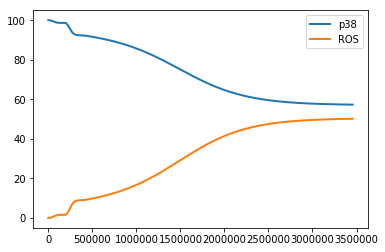

In [113]:
#TEMP
r.resetAll()
r.simulate(0, DAY*40, 12000, ["time", "p38", "ROS"])
r.plot()

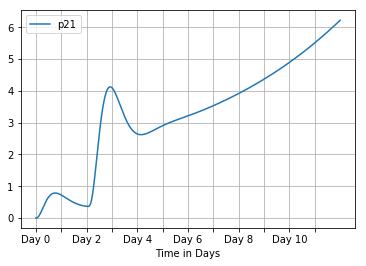

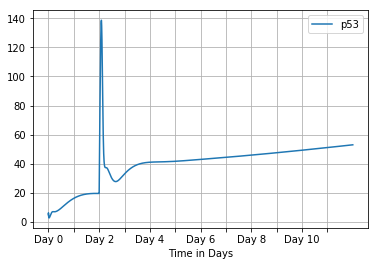

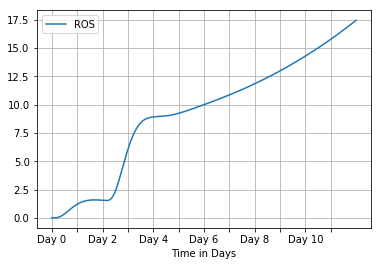

In [95]:
#Show the growth of one parameter without any scanning.
def showBasicSingleParameterPlot(parameterName):
    r.resetAll()
    result = r.simulate(0, TIME_LIMIT, 12000, ["time", parameterName])
    X_LIM = np.arange(0, TIME_LIMIT, DAY)
    X_TICKS = ['Day '+str(n) if n%2==0 else '' for n in np.arange(0, 14, 1)]

    # plt.figure (figsize=(10,4))
    plt.grid(True)
    plt.interactive(False)
    plt.plot(result[:,0], result[:,1])
    plt.xticks(X_LIM, X_TICKS)
    plt.xlabel("Time in Days")
    plt.legend([parameterName])

    plt.show(block=True)
    plt.close()
    
showBasicSingleParameterPlot('p21')
showBasicSingleParameterPlot('p53')
showBasicSingleParameterPlot('ROS')

A certain level of DNA damage is necessary to push ROS into a higher fixed point. Try raising and lowering the intensity of radiation so that more DNA is damaged. Find how much IR is needed to trigger a higher steady-state concentration of ROS.

In [96]:
#Let user adjust the amount of radiation and see the effect on one parameter
parameterName = "ROS"

def rePlot(radiationDay, maxDays, intensity):
    r.resetAll()
    
    r.irDoseTime = radiationDay * DAY
    r.irIntensity = intensity
    
    result = r.simulate(0, DAY*maxDays, 12000, ["time", parameterName])
    X_LIM = np.arange(0, DAY*maxDays, DAY)
    X_TICKS = [n if n%5==0 else '' for n in np.arange(0, maxDays, 1)]
    
    # plt.figure (figsize=(10,4))
    plt.grid(True)
    plt.interactive(False)
    dataToPlot = [0]*2
    for i in range(0,2):
        dataToPlot[i] = result[:,i]
    plt.plot(*dataToPlot)
    plt.xticks(X_LIM, X_TICKS)
    plt.xlabel("Time in Days")
    plt.legend([parameterName])
    plt.title("Effect of Radiation on %s"%(parameterName))

    plt.show(block=True)

style = {'description_width': 'auto'}
layout = {'width': '375px'}
#TODO maybe slider1 is not needed
slider1 = IntSlider(description = 'Day IR is Applied:', min=0, max=30, step=1, value=2, continuous_update=False, style=style, layout=layout)
slider2 = IntSlider(description = 'Days in Simulation:', min=2, max=50, step=1, value=40, continuous_update=False, style=style, layout=layout)
slider3 = IntSlider(description = 'IR Intensity:', min=0, max=100, step=1, value=20, continuous_update=False, style=style, layout=layout)
interact(rePlot, radiationDay=slider1, maxDays = slider2, intensity = slider3);

interactive(children=(IntSlider(value=2, continuous_update=False, description='Day IR is Applied:', layout=Layout(width='375px'), max=30, style=SliderStyle(description_width='auto')), IntSlider(value=40, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=50, min=2, style=SliderStyle(description_width='auto')), IntSlider(value=20, continuous_update=False, description='IR Intensity:', layout=Layout(width='375px'), style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

You should have seen that 9 Gy of IR is sufficient to push ROS into a higher steady state. We'll see below that the DDR proteins increase in quantity as ROS is increased, eventually triggering the feedback loop between DDR and ROS. Hence, the higher steady state of ROS occurs during this feedback loop.

In [97]:
#Temporary: wanted to get steady states
# r.resetAll()
# r.IR = 90
# print(r.getSteadyStateValues())

In [134]:
#A delay-based plot showing the effect of different levels of radiation on any plot
maxDays = 100
plotStartDay = 35 #steady state day for most parameters

def perturbRadiationAtSteadyState(parameterName, showLegend=True):
    radiationDay = plotStartDay + 5 #5 is an arbitrary amount of space
    plt.figure (figsize=(10,4))
    for perturb in np.arange(0.0, 20, 2.0):
        r.resetAll()
        r.irIntensity=perturb
        r.irDoseDuration = 60 #1min
        r.irDoseTime = radiationDay * DAY
        radiationDay += 2
        r.simulate(0, plotStartDay*DAY, 1000, ["time", parameterName]) #get to steady state before plotting
        m = r.simulate(plotStartDay*DAY, DAY*maxDays, 1000, ["time", parameterName])
        te.plotArray(m, show=False, title="%s Response to Perturbations of IR Intensity"%(parameterName), resetColorCycle=False, 
                     labels=['IR = %.1f'%(perturb)] if showLegend else None)

    X_LIM = np.arange(plotStartDay*DAY, DAY*maxDays, DAY)
    X_TICKS = [n if n % 5==0 else '' for n in np.arange(plotStartDay, maxDays, 1)]
    plt.grid(True)
    plt.xticks(X_LIM, X_TICKS)
    plt.xlabel("Time in Days")
    plt.ylabel("Concentration of "+parameterName)
    plt.show()
    
def showAllPlots(showLegend):
    perturbRadiationAtSteadyState("p21", showLegend)
    perturbRadiationAtSteadyState("p38", showLegend)
    perturbRadiationAtSteadyState("p53", showLegend)
    
checkbox = Checkbox(description = 'Show legend', value=True, style=style, layout=layout)
interact(showAllPlots, showLegend=checkbox);

interactive(children=(Checkbox(value=True, description='Show legend', layout=Layout(width='375px'), style=DescriptionStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

#### Observations
A spike in a protein's concentration signifies a DNA damage response event, which is rapidly repaired. However, if a protein stays at a high concentration, that may be indicative of the senescence feedback loop.
An IR intensity of 12 Gy is sufficient to knock every one of the 3 proteins here into a different steady state. Hence, a high concentration of ROS suggests (but does not necessarily guarantee) senescence. Conversely, low ROS suggests no senescence but possible quiescence (a temporary cease of cellular proliferation). 

#### Decreases in p38 (MAPK14)
Of the 3 proteins above, p38 is the only one to decline in response to IR. This is because p38 is phosphorylated to p38_P more quickly in these conditions. High levels of p38, in fact, lead to apoptosis due to the p38-JNK† pathway (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797964/) [TODO fix citation].
In other words, p38 "tips the balance" towards apoptosis in cells stressed by ROS or DNA damage (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8533283/).

Generally speaking, p38 is upstream of transforming growth factor-beta (TGFβ), and activation of one or both leads to ROS production (Torres and Forman, 2003; Koli et al, 2008 https://pubmed.ncbi.nlm.nih.gov/17961070/) [TODO fix citation]. At the same time, TGFβ itself induces ROS production for a positive feedback loop (Koli et al, 2008). Meanwhile, p53 does not directly interact with the mitochondria, but ultimately stimulates ROS production by being upstream of TGFβ (Passos et al.).

 † c-Jun N-terminal kinase (JNK) (https://pubmed.ncbi.nlm.nih.gov/18206122 Matsuzawa et al.), when activated by ROS, moves FoxO3a, a transcription factor for CDKN1A, to the nucleus through phosphorylation (https://pubmed.ncbi.nlm.nih.gov/16288288 and https://pubmed.ncbi.nlm.nih.gov/18171426). FoxO3a then promotes p21, thus controlling cell cycle arrest (https://pubmed.ncbi.nlm.nih.gov/16288288 and https://pubmed.ncbi.nlm.nih.gov/14976264).

Given that phosphorylated p38 is capable of generating ROS, let's try inhibitng p38_P.

In [137]:
#Let user adjust the inhibition of p38, then observe the effect on ROS

def plotColumn(plt, result):
    for i in range(1, 3):
        plt.plot(result[:,0], result[:,i])
    plt.legend(["p38_P", "ROS"])


def getDataWithTherapy(stop_p38_ROS_day, maxDays):
    r.resetAll()
#     r.irDoseTime = 0 #radiationDay * DAY
#     r.irIntensity = 20 #intensity
    r.stopp38ROSTime = stop_p38_ROS_day * DAY
    
    return r.simulate(0, DAY*maxDays, 12000, ["time", "p38", "ROS"])

def getDataControlGroup(maxDays):
    r.resetAll()  
    r.stopp38ROSTime = maxDays * 2 * DAY #never happens in our view
    
    return r.simulate(0, DAY*maxDays, 12000, ["time", "p38_P", "ROS"])
    

def plotP38Inhibition(stop_p38_ROS_day, maxDays):
    X_LIM = np.arange(0, DAY*maxDays, DAY)
    X_TICKS = [n if n%5==0 else '' for n in np.arange(0, maxDays, 1)]
        
    fig, axes = plt.subplots(1, 2)  # + kwarg arguments https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    
    for k in range(0, len(axes)):
        subplot = axes[k]
        subplot.figure.set_size_inches(10, 4)
        subplot.grid(True)
        
        plt.sca(axes[k])
        plt.interactive(False)
        plt.xticks(X_LIM, X_TICKS)
        plt.xlabel("Time in Days")
        
    #Plot data with p38 inhibition
    axes[0].set_title("Effect of Inhibiting p38 on ROS")
    plt.sca(axes[0])
    result = getDataWithTherapy(stop_p38_ROS_day, maxDays)
    plotColumn(plt, result)
    
    #Plot control group data
    axes[1].set_title("Control Group (No Inhibition of p38)")
    plt.sca(axes[1])
    result = getDataControlGroup(maxDays)
    plotColumn(plt, result)
    
    plt.tight_layout() # makes sure there's no overlap of axes, titles, ticks, etc
    plt.show()

style = {'description_width': 'auto'}
layout = {'width': '375px'}
slider1 = IntSlider(description = 'Day to Inhibit p38:', min=0, max=30, step=1, value=6, continuous_update=False, style=style, layout=layout)
slider2 = IntSlider(description = 'Days in Simulation:', min=2, max=50, step=1, value=40, continuous_update=False, style=style, layout=layout)
interact(plotP38Inhibition, stop_p38_ROS_day=slider1, maxDays = slider2);

interactive(children=(IntSlider(value=6, continuous_update=False, description='Day to Inhibit p38:', layout=Layout(width='375px'), max=30, style=SliderStyle(description_width='auto')), IntSlider(value=40, continuous_update=False, description='Days in Simulation:', layout=Layout(width='375px'), max=50, min=2, style=SliderStyle(description_width='auto')), Output()), _dom_classes=('widget-interact',))

ROS indeed decreases upon inhibiting p38_P. This is because the rate at which p38_P generates ROS was decreased to 60% of its normal rate. Note the radiation event of 20 Gy at day 2.

In [15]:
#Phase portrait
# PLOT_SIZE = 50
# Y, X = np.mgrid[0:PLOT_SIZE:400j, 0:50:400j]
# U, V = np.mgrid[0:PLOT_SIZE:400j, 0:50:400j]
# r.resetAll()
# for idx in range (400):
#     for idy in range (400):
#         r.p21 = X[idx,idy]
#         r.ROS = Y[idx,idy]
#         U[idx,idy] = r["p21'"]
#         V[idx,idy] = r["ROS'"]
# plt.subplots(1,2, figsize=(8,6))
# plt.subplot(111)
# plt.xlabel('p21', fontsize='16')
# plt.ylabel('ROS', fontsize='16')
# plt.streamplot(X, Y, U, V, density=[2, 2])
# plt.ylim((0, PLOT_SIZE))
# plt.xlim((0, PLOT_SIZE))
# plt.show()

In [16]:
# #Exercise: Removing parameters from the complete senesence pathway.  
# r = te.loada(model)
# def rePlot(parameterToRemove):
#     r.reset()
#     DAY_COUNT = 8
    
#     #DNA damage -> TP53 -> CDKN1A -> GADD45 -> MAPK14 -> TGFβ -> mitochondrial dysfunction and increased production of ROS -> more DNA damage (cycle continues)
#     parameterList = ["time", "p53", "p21", "GADD45", "p38", "ROS"]
#     if parameterToRemove in parameterList:
#         parameterList.remove(parameterToRemove)
#     result = r.simulate(0, DAY*DAY_COUNT, 20000, parameterList)
# #     for i in range(0, len(result)):
# #         result[i, parameterToRemove] = 0
#     X_LIM = np.arange(0, DAY*DAY_COUNT, DAY)
#     X_TICKS = [n if n%2==0 else '' for n in np.arange(0, DAY_COUNT, 1)]
    
# #     plt.figure (figsize=(10,8))
#     plt.grid(True)
#     plt.interactive(False)
#     for i in range(1, len(parameterList)):
#         plt.plot(result[:,0], result[:,i])
# #     plt.xticks(X_LIM, X_TICKS)
#     plt.xlabel("Time in Days")
#     parameterList.remove("time")
#     plt.legend(parameterList)
#     if parameterToRemove == "Nothing":
#         plt.title("Complete Senescence Process")
#     else:
#         plt.title("Senescence Process without "+parameterToRemove)

#     plt.show(block=True)

# #Create toggle buttons
# toggle = widgets.ToggleButtons(
#     options=["Nothing", "p53", "p21", "GADD45", "p38", "ROS"],
#     description='Parameter to Remove:',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
# )
# ui = widgets.HBox([toggle])
# out = widgets.interactive_output(rePlot, {'parameterToRemove': toggle})
# display(ui, out)

In [17]:
#Exercise: Relationship between one protein and ROS
r = te.loada(model)
def rePlot(parameter):
    r.reset()
    DAY_COUNT = 8
    
    parameterList = ["time", parameter, "ROS"]
    result = r.simulate(0, DAY*DAY_COUNT, 20000, parameterList)
    X_LIM = np.arange(0, DAY*DAY_COUNT, DAY)
    X_TICKS = [n if n%2==0 else '' for n in np.arange(0, DAY_COUNT, 1)]
    
    plt.grid(True)
    plt.interactive(False)
    for i in range(1, len(parameterList)):
        plt.plot(result[:,0], result[:,i])
    plt.xlabel("Time in Days")
    parameterList.remove("time")
    plt.legend(parameterList)
    plt.title("Senescence Process with "+parameter)

    plt.show(block=True)
    plt.close()

#Create toggle buttons
toggle = widgets.ToggleButtons(
    options=["p53", "p21", "GADD45", "p38", "ROS"],
    description='Parameter to Show:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)
ui = widgets.HBox([toggle])
out = widgets.interactive_output(rePlot, {'parameter': toggle})
display(ui, out)

HBox(children=(ToggleButtons(description='Parameter to Show:', options=('p53', 'p21', 'GADD45', 'p38', 'ROS'), value='p53'),))

Output()

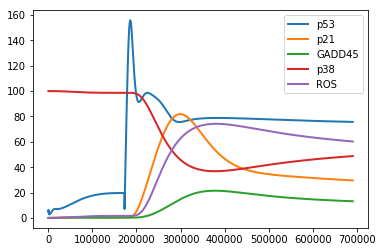

In [14]:
r.resetAll()
DAY_COUNT = 8
result = r.simulate(0, DAY*DAY_COUNT, 20000, ["time", "p53", "p21", "GADD45", "p38", "ROS"])
r.plot()

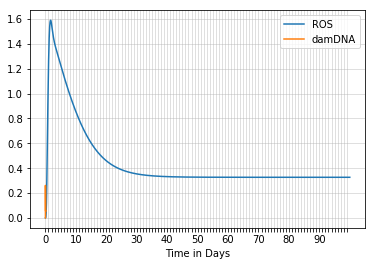

In [35]:
#TODO: Scale damDNA so that it is logarithmic
r.resetAll()
# r.stopp38ROSTime = DAY*30
MAX_DAYS = 100
result = r.simulate(0, DAY*MAX_DAYS, 10000, ["time","ROS","damDNA"])
X_LIM = np.arange(0, DAY*MAX_DAYS, DAY)
X_TICKS = [n if n%10==0 else '' for n in np.arange(0, MAX_DAYS, 1)]

# plt.figure (figsize=(10,4))
plt.grid(True, alpha=0.5, which='major')
plt.interactive(False)
plt.plot(result[:,0], result[:,1], result[:,2])
# plt.plot(result[:,0], result[:,2])
plt.xticks(X_LIM, X_TICKS)
# plt.xticks(X_LIM, X_TICKS, minor=True)
plt.xlabel("Time in Days")
plt.legend(["ROS","damDNA"])

plt.show(block=True)

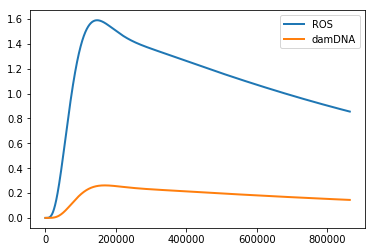

In [36]:
r.resetAll()
r.irIntensity = 0
r.irDoseDuration = 0
result = r.simulate(0, DAY*10, 10000, ["time","ROS","damDNA"])
r.plot()

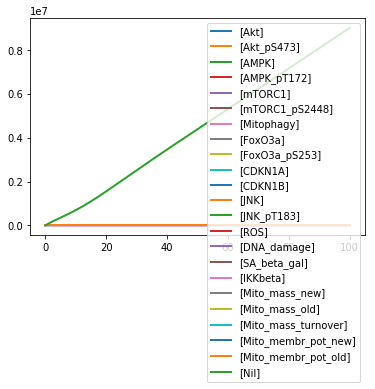

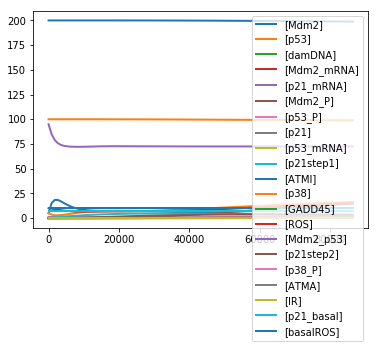

In [42]:
#Temporary plot to track the parameter list
r.resetAll()
result = r.simulate(0, DAY, 100)
r.plot()

Sources

https://pubmed.ncbi.nlm.nih.gov/18206122
Matsuzawa A, Ichijo H (2008) Redox control of cell fate by MAP kinase: physiological roles of ASK1-MAP kinase pathway in stress signaling. Biochimica Et Biophysica Acta-General Subjects 1780: 1325–1336.

https://pubmed.ncbi.nlm.nih.gov/16288288
Greer EL, Brunet A (2005) FOXO transcription factors at the interface between longevity and tumor suppression. Oncogene 24: 7410–7425. [PubMed] [Google Scholar]

https://pubmed.ncbi.nlm.nih.gov/18171426
Greer EL, Brunet A (2008) FOXO transcription factors in ageing and cancer. Acta Physiologica 192: 19–28. [PubMed] [Google Scholar]
    
https://pubmed.ncbi.nlm.nih.gov/14976264
Brunet A, Sweeney LB, Sturgill JF, Chua KF, Greer PL, et al. (2004) Stress-dependent regulation of FOXO transcription factors by the SIRT1 deacetylase. Science 303: 2011–2015.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8533283/
Robert H. Whitaker and Jeanette Gowen Cook